In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import copy
import abc

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from numpy.random import default_rng
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading UCI datasets

In [2]:
yeast = pd.read_csv("yeast.csv")
yeast_data = yeast.drop("Sequence Name", axis=1)

bean = pd.read_csv("dry_bean.csv")
bean_data = bean.rename(columns={"Class": "label"})

letter_data = pd.read_csv('letter-recognition.data', names = ['label']+[f'x{i}' for i in range(16)])

shuttle_train = pd.read_csv('shuttle.trn', sep=' ', names = [f'x{i}' for i in range(9)]+['label'])
shuttle_test = pd.read_csv('shuttle.tst', sep=' ', names = [f'x{i}' for i in range(9)]+['label'])
shuttle_data = pd.concat([shuttle_train, shuttle_test])

In [3]:
def create_rewards(df, y_col, drop_context=False):
    
    classes = df[y_col].unique()
    contexts = df.drop(y_col, axis=1).columns
    df = pd.concat([df, pd.DataFrame(columns=classes)], axis=1).fillna(0)
    
    def fill_in_rewards(row, classes):
        label = row[y_col]
        row.loc[label] = 1
        return row
    
    df = df.apply(fill_in_rewards, axis=1, args=[classes])
    if drop_context:
        df = df.drop(contexts, axis=1)
    
    return df

### Setting up Target Policy

In [4]:
class Policy:
    def __init__(self, num_actions=2):
        self.num_actions = num_actions

    @abc.abstractmethod
    def get_action_distribution(self, X):
        raise NotImplementedError("Must override method")

    def get_action_propensities(self, X, actions):
        distrib = self.get_action_distribution(X)
        distrib["action"] = actions
        return distrib.apply(lambda x : x[x["action"]], axis=1)
        
    def select_actions(self, X, rng=default_rng(1)):
        df = self.get_action_distribution(X)
        action_list = df.columns
        
        df["actions"] = df.apply(lambda x : np.random.choice(action_list, p=x), axis=1)
        actions = df["actions"]
        propensities = self.get_action_propensities(X, actions)
        
        return actions, propensities
        
    def get_value_estimate(self, X, full_rewards):
        actions, propensities = self.select_actions(X)
        df = pd.DataFrame(full_rewards.reset_index(drop=True)).assign(act = actions)
        action_rewards = df.apply(lambda x : x[x["act"]], axis=1)
        
        return action_rewards.mean()

In [5]:
class SKLearnPolicy(Policy):
    """ 
    An SKLearnPolicy uses a scikit learn model to generate an action distribution.  If the SKLearnPolicy is built with is_deterministic=False, 
    then the predict distribution for a context x should be whatever predict_proba for the model returns.  If is_deterministic=True, then all the probability mass 
    should be concentrated on whatever predict of the model returns.
    """
    def __init__(self, model, num_actions=2, is_deterministic=False):
        self.is_deterministic = is_deterministic
        self.num_actions = num_actions
        self.model = model

    def get_action_distribution(self, X):
        prob = pd.DataFrame(self.model.predict_proba(X), columns=self.model.classes_)
        action = self.model.predict(X)
        
        def deterministic(row):
            pred = row["act"]
            row[pred] = 1
            return row
        
        if (self.is_deterministic):
            df = pd.DataFrame(np.zeros(prob.shape), columns=self.model.classes_).assign(act=action)
            df = df.apply(deterministic, axis=1).drop("act", axis=1)
        else:
            df = copy.deepcopy(prob)

        return df

    def select_actions(self, X, rng=default_rng(1)):
        if (self.is_deterministic):
            actions = pd.DataFrame(self.model.predict(X))
            propensities = pd.Series([1 for i in range(len(actions))])
        else:
            df = self.get_action_distribution(X)
            action_list = df.columns
            df["actions"] = df.apply(lambda x : np.random.choice(action_list, p=x), axis=1)
            actions = df["actions"]
            propensities = self.get_action_propensities(X, actions)
            
        return actions, propensities

### Setting up Logging Policy

In [6]:
class BanditLoggingPolicy(Policy):
    """
    This policy derives from another deterministic policy following the recipe described in the Vlassis et al paper, on the top of the second column in section 5.3.
    For any context x, if the deterministic policy selects action a, then this policy selects action a with probability eps (a supplied parameter), and spreads the
    rest of the probability mass uniformly over the other actions.
    """
    def __init__(self, num_actions=2, eps=0.3, actions=None, classes=None):
        self.num_actions = num_actions
        self.eps = eps
        self.actions = actions.reset_index(drop=True)
        self.classes = classes
        
    def get_action_distribution(self, X):
        
        def bandit_sampling(row, classes):
            pred = row["act"]
            s_a = np.random.uniform(0.1, 1, len(self.classes))
            row[row.index!="act"] +=  s_a/s_a.sum()*(1-self.eps) # take care of actions
            row[pred] += self.eps
            return row
        
        df = pd.DataFrame(np.zeros([X.shape[0], self.num_actions]), columns=self.classes).assign(act=self.actions)
        df = df.apply(bandit_sampling, axis=1, args=[self.classes]).drop("act", axis=1)
        return df
    
class BanditLoggingPolicyWithFeatureDependency(Policy):
    def __init__(self, num_actions=2, eps=5, actions=None, classes=None):
        self.num_actions = num_actions
        self.eps = eps
        self.actions = actions.reset_index(drop=True)
        self.classes = classes
        
    def get_action_distribution(self, X):
        features = list(X.columns)
        n_features = len(features)
        selected_features = np.random.choice(features, size=self.eps, replace=False)
        X_less_feature = X[selected_features]
        model = LogisticRegression(multi_class="multinomial")
        model.fit(X_less_feature, self.actions)
        prob = model.predict_proba(X_less_feature)
        df = pd.DataFrame(prob, columns=model.classes_)
        
        return df

In [7]:
def generate_bandit_feedback(contexts, full_rewards, policy, rng=default_rng(1)):
    """   
    Args:
        contexts (np.array): contexts, rows correspond to entries of rewards
        full_rewards (np.array): 2-dim numpy array with the same number of rows as X and number of columns corresponding to the number actions
            each row gives the reward that would be received for each action for the context in the corresponding row of X. 

    Returns:
        new_contexts (np.array): new_n rows and same number of columns as in contexts
        actions (np.array): vector with new_n entries giving actions selected by the provided policy for the contexts in new_contexts
        observed_rewards (np.array): vector with new_n entries giving actions selected by the provided policy for the contexts in new_contexts 
    """   
    
    n, k = full_rewards.shape
    new_contexts = contexts
    actions, propensities = policy.select_actions(X=new_contexts, rng=rng)
    obs_rewards = full_rewards.reset_index(drop=True).assign(act=actions)
    obs_rewards["obs_r"] = obs_rewards.apply(lambda x : x[x["act"]], axis=1)
    observed_rewards = obs_rewards["obs_r"]
    return new_contexts, actions, observed_rewards, propensities

### Creating value estimators

In [18]:
def get_value_estimators(policy, contexts, actions, rewards, propensities, skip_slow_stuff=False):
    """   
    Args:
        policy (Policy): the policy we want to get a value estimate for
        contexts (np.array): contexts from bandit feedback
        actions (np.array): actions chosen for bandit feedback
        rewards (np.array): rewards received in bandit feedback
        propensities (np.array): the propensity for each action selected under the logging policy (which is not provided to this function)
        skip_slow_stuff (boolean): boolean flag which allows you to turn on/off some slow estimators (ignore this if you like)
    Returns:
        est (dict): keys are string describing the value estimator, values are the corresponding value estimates 
    """   

    est = {}
    new_propensities = policy.get_action_propensities(contexts, actions)
    new_propensities.to_csv("prp.csv")
    imp_wgt = new_propensities / propensities
    
    est["iw"] = np.mean(rewards*imp_wgt)
    est["sn-iw"] = np.sum(rewards*imp_wgt) / np.sum(imp_wgt)

    merged = pd.DataFrame(contexts.reset_index(drop=True)).assign(
        act=actions.reset_index(drop=True)).assign(r=rewards.reset_index(drop=True)).assign(wgt=imp_wgt)
    rewards_linreg, rewards_linreg_iw = pd.DataFrame(), pd.DataFrame()
#     rewards_poly5 = pd.DataFrame()
    rewards_rf = pd.DataFrame()
    
    for act in sorted(list(set(actions))):
        df = merged.loc[merged["act"]==act]
        X, R, wgt = df.drop(columns=["act","r", "wgt"]), df["r"], df["wgt"]
        
        # Direct method with linear ridge regression
        rewards_linreg[act] = RidgeCV([1e-3, 1e-2, 1e-1]).fit(X,R).predict(contexts)
        rewards_linreg_iw[act] = RidgeCV([1e-3, 1e-2, 1e-1]).fit(X,R, sample_weight=wgt).predict(contexts)
        
        # Direct method with polynomial regression
#         poly5 = make_pipeline(PolynomialFeatures(5),LinearRegression())
#         rewards_poly5[act] = poly5.fit(X,R).predict(contexts)      
        
        # Direct method with a non-linear reward predictor
        rf = RandomForestRegressor()
        params = {'n_estimators': [100, 150], 
                  'max_depth': [5, 10]}
        rewards_rf[act] = GridSearchCV(rf, params, cv=3).fit(X,R).predict(contexts)

    act_dist = policy.get_action_distribution(contexts)
    rewards_dbly_lin = (rewards_linreg).assign(act=actions).apply(lambda x: x[x["act"]], axis=1)
#     rewards_dbly_poly = (rewards_poly5).assign(act=actions).apply(lambda x: x[x["act"]], axis=1)
    rewards_dbly_rf = (rewards_rf).assign(act=actions).apply(lambda x: x[x["act"]], axis=1)
    
    est["dm-lin"] = (rewards_linreg * act_dist).sum().sum() / act_dist.shape[0]
    est["dm-iw-lin"] = (rewards_linreg_iw * act_dist).sum().sum() / act_dist.shape[0]
    est["dbly-lin"] = (((rewards-rewards_dbly_lin)*imp_wgt).sum() + 
                                (rewards_linreg*act_dist).sum().sum()) / act_dist.shape[0]
    
#     est["dm-poly5"] = (rewards_poly5 * act_dist).sum().sum() / act_dist.shape[0]
#     est["dbly-poly5"] = (((rewards-rewards_dbly_poly)*imp_wgt).sum() + 
#                                 (rewards_poly5*act_dist).sum().sum()) / act_dist.shape[0]
    
    est["dm-rf"] = (rewards_rf * act_dist).sum().sum() / act_dist.shape[0]
    est["dbly-rf"] = (((rewards-rewards_dbly_rf)*imp_wgt).sum() + 
                                (rewards_rf*act_dist).sum().sum()) / act_dist.shape[0]
    return est

In [19]:
def get_estimator_stats(estimates, eps, true_parameter_value=None):
    est_stat = []
    for est in estimates.columns:
        pred_means = estimates[est]
        stat = {}
        stat['stat'] = est
        stat['mean'] = np.mean(pred_means)
        stat['SD'] = np.std(pred_means)
        stat['SE'] = np.std(pred_means) / np.sqrt(len(pred_means))
        if true_parameter_value:
            stat['bias'] = stat['mean'] - true_parameter_value
            stat['RMSE'] = np.sqrt(np.mean((pred_means - true_parameter_value) ** 2))
        stat['eps'] = eps
        est_stat.append(stat)

    return pd.DataFrame(est_stat)

#### picked stochastic policy here (deterministic policy has risk of getting 0 weights in the propensities)

In [20]:
def value_est_output(data, rewards, model, TargetPolicy, LoggingPolicy, trials=5, rng=default_rng(7), eps=0.5, policy_true_value=None):
    
    X_train, X_test, y_train, y_test = data["X_train"], data["X_test"], data["y_train"], data["y_test"]
    full_rewards_test = rewards
    
    classes, k = model.classes_, len(model.classes_)
    logging_policy = LoggingPolicy(num_actions=k, eps=eps, actions=y_test, classes=classes)
    logging_policy_value = logging_policy.get_value_estimate(X=X_test, full_rewards=full_rewards_test)   
    print(f"Logging policy value est: {logging_policy_value:.6f}")
    print(f"Target policy true value: {policy_true_value:.6f}")
    
    val_ests = []    
    for i in range(trials):
        contexts, actions, rewards, propensities = generate_bandit_feedback(X_test, full_rewards_test, logging_policy, rng=rng)
        est = get_value_estimators(TargetPolicy, contexts, actions, rewards, propensities)
        val_ests.append(est)
    df = pd.DataFrame(val_ests)
    
    return get_estimator_stats(df, eps, true_parameter_value=policy_true_value) 

### Part 1. Run experiments with BanditLoggingPolicy
(Controlling the bias of the logging policy with eps)

### Yeast data results

- \# of classes = 10
- Sample size = 1,484

In [21]:
def run_experiments(data, LoggingPolicy, eps_list, rng=default_rng(7)):
    gb = GradientBoostingClassifier()
    
    pipe_lr = Pipeline([("classifier", LogisticRegression(multi_class="multinomial"))])

    param_grid_lr = [{'classifier' :[LogisticRegression(multi_class="multinomial")],
                      "classifier__penalty" : ['l1', 'l2'],
                      "classifier__C" : np.logspace(-4, 4, 10),
                      "classifier__max_iter" : [100]}]

    clf_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=3, verbose=0, n_jobs=-1)

    lr_results = []
    gb_results = []
    
    # Prep data
    n = data.shape[0]
    train_frac = 0.7
    train_size = round(train_frac * n)
    train_idx = rng.choice(n, size = train_size, replace = False)
    test_idx = np.setdiff1d(np.arange(n), train_idx, assume_unique=True)

    data_context, data_label = data.drop("label", axis=1), data["label"]
    
    X_train, y_train = data_context.iloc[train_idx], data_label.iloc[train_idx]
    X_test, y_test = data_context.iloc[test_idx], data_label.iloc[test_idx]
    
    full_rewards = create_rewards(data, "label", True)
    full_rewards_test = full_rewards.iloc[test_idx].drop("label", axis=1)

    data_dict = {"X_train": X_train, "X_test": X_test, "y_train" : y_train, "y_test": y_test}
    
    clf_lr.fit(X_train, y_train)
    lr_policy_stochastic = SKLearnPolicy(model=clf_lr, num_actions=len(data.label.unique()), is_deterministic=False)
    lr_policy_true_value = lr_policy_stochastic.get_value_estimate(X_test, full_rewards_test)
    
    gb.fit(X_train, y_train)
    gb_policy_stochastic = SKLearnPolicy(model=gb, num_actions=len(data.label.unique()), is_deterministic=False)
    gb_policy_true_value = gb_policy_stochastic.get_value_estimate(X_test, full_rewards_test)
    
    for e in eps_list:
        print(LogisticRegression(multi_class="multinomial"))
        lr_res = value_est_output(data_dict, full_rewards_test,  model=clf_lr, LoggingPolicy=LoggingPolicy, 
                                  TargetPolicy=lr_policy_stochastic,
                                  eps=e, policy_true_value=lr_policy_true_value)
        display(lr_res)

        print(gb)
        gb_res = value_est_output(data_dict, full_rewards_test, model=gb, LoggingPolicy=LoggingPolicy, 
                                  TargetPolicy=gb_policy_stochastic,
                                  eps=e, policy_true_value=gb_policy_true_value)
        display(gb_res)

        lr_results.append(lr_res)
        gb_results.append(gb_res)

    lr_results = pd.concat(lr_results, ignore_index=True)
    gb_results = pd.concat(gb_results, ignore_index=True)
    
    return lr_results, gb_results

In [22]:
eps_list = [0.1, 0.2, 0.4, 0.6, 0.8] 
yeast_lr_results, yeast_gb_results = run_experiments(yeast_data, BanditLoggingPolicy, eps_list)

LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.240449
Target policy true value: 0.467416


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.427383,0.037427,0.016738,-0.040033,0.054803,0.1
1,sn-iw,0.338404,0.037907,0.016953,-0.129012,0.134466,0.1
2,dm-lin,0.476242,0.028145,0.012587,0.008826,0.029497,0.1
3,dm-iw-lin,0.386263,0.038335,0.017144,-0.081153,0.089751,0.1
4,dbly-lin,0.319415,0.061238,0.027386,-0.148000,0.160169,0.1
5,dm-poly5,0.618251,0.414554,0.185394,0.150835,0.441142,0.1
6,dbly-poly5,0.618251,0.414554,0.185394,0.150835,0.441142,0.1
7,dm-rf,0.506175,0.030470,0.013627,0.038759,0.049302,0.1
8,dbly-rf,0.427857,0.055317,0.024739,-0.039558,0.068006,0.1


GradientBoostingClassifier()
Logging policy value est: 0.193258
Target policy true value: 0.530337


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.508280,0.020840,0.009320,-0.022057,0.030345,0.1
1,sn-iw,0.430710,0.043248,0.019341,-0.099627,0.108609,0.1
2,dm-lin,0.528323,0.030101,0.013462,-0.002014,0.030168,0.1
3,dm-iw-lin,0.494032,0.067012,0.029969,-0.036305,0.076215,0.1
4,dbly-lin,0.439204,0.069046,0.030878,-0.091133,0.114336,0.1
5,dm-poly5,0.680284,0.406428,0.181760,0.149947,0.433206,0.1
6,dbly-poly5,0.680284,0.406428,0.181760,0.149947,0.433206,0.1
7,dm-rf,0.565553,0.021629,0.009673,0.035216,0.041328,0.1
8,dbly-rf,0.518235,0.041935,0.018754,-0.012102,0.043646,0.1


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.271910
Target policy true value: 0.467416


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.434797,0.045016,0.020132,-0.032618,0.055591,0.2
1,sn-iw,0.357539,0.068216,0.030507,-0.109877,0.129330,0.2
2,dm-lin,0.593881,0.057001,0.025492,0.126466,0.138718,0.2
3,dm-iw-lin,0.443868,0.067523,0.030197,-0.023547,0.071511,0.2
4,dbly-lin,0.351398,0.094637,0.042323,-0.116018,0.149721,0.2
5,dm-poly5,0.965484,0.363987,0.162780,0.498069,0.616894,0.2
6,dbly-poly5,0.965484,0.363987,0.162780,0.498069,0.616894,0.2
7,dm-rf,0.604232,0.044752,0.020014,0.136816,0.143950,0.2
8,dbly-rf,0.498634,0.059277,0.026510,0.031218,0.066995,0.2


GradientBoostingClassifier()
Logging policy value est: 0.274157
Target policy true value: 0.530337


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.533180,0.035503,0.015878,0.002843,0.035617,0.2
1,sn-iw,0.442210,0.039869,0.017830,-0.088127,0.096726,0.2
2,dm-lin,0.643412,0.025989,0.011622,0.113075,0.116023,0.2
3,dm-iw-lin,0.524672,0.020839,0.009320,-0.005665,0.021595,0.2
4,dbly-lin,0.449643,0.038837,0.017368,-0.080694,0.089554,0.2
5,dm-poly5,0.900636,0.477408,0.213503,0.370298,0.604185,0.2
6,dbly-poly5,0.900636,0.477408,0.213503,0.370298,0.604185,0.2
7,dm-rf,0.656491,0.029742,0.013301,0.126154,0.129613,0.2
8,dbly-rf,0.552019,0.038659,0.017289,0.021682,0.044324,0.2


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.494382
Target policy true value: 0.467416


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.443983,0.011700,0.005232,-0.023433,0.026192,0.4
1,sn-iw,0.398699,0.033470,0.014968,-0.068717,0.076435,0.4
2,dm-lin,0.742415,0.020628,0.009225,0.275000,0.275772,0.4
3,dm-iw-lin,0.517450,0.031431,0.014057,0.050034,0.059087,0.4
4,dbly-lin,0.421809,0.049655,0.022206,-0.045606,0.067421,0.4
5,dm-poly5,0.532056,0.510357,0.228238,0.064641,0.514434,0.4
6,dbly-poly5,0.532056,0.510357,0.228238,0.064641,0.514434,0.4
7,dm-rf,0.738610,0.010856,0.004855,0.271195,0.271412,0.4
8,dbly-rf,0.574379,0.047522,0.021252,0.106963,0.117045,0.4


GradientBoostingClassifier()
Logging policy value est: 0.435955
Target policy true value: 0.530337


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.518858,0.022546,0.010083,-0.011479,0.025300,0.4
1,sn-iw,0.401147,0.071313,0.031892,-0.129190,0.147566,0.4
2,dm-lin,0.739485,0.010134,0.004532,0.209148,0.209393,0.4
3,dm-iw-lin,0.501223,0.063298,0.028308,-0.029114,0.069673,0.4
4,dbly-lin,0.322940,0.141149,0.063124,-0.207397,0.250871,0.4
5,dm-poly5,1.063945,0.722185,0.322971,0.533608,0.897936,0.4
6,dbly-poly5,1.063945,0.722185,0.322971,0.533608,0.897936,0.4
7,dm-rf,0.758184,0.020327,0.009091,0.227846,0.228751,0.4
8,dbly-rf,0.543731,0.083686,0.037425,0.013394,0.084751,0.4


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.696629
Target policy true value: 0.467416


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.442514,0.019587,0.008760,-0.024902,0.031682,0.6
1,sn-iw,0.369251,0.014373,0.006428,-0.098165,0.099212,0.6
2,dm-lin,0.822292,0.008402,0.003758,0.354876,0.354976,0.6
3,dm-iw-lin,0.504910,0.015468,0.006918,0.037494,0.040560,0.6
4,dbly-lin,0.339047,0.026619,0.011905,-0.128369,0.131099,0.6
5,dm-poly5,0.932493,0.206847,0.092505,0.465077,0.509001,0.6
6,dbly-poly5,0.932493,0.206847,0.092505,0.465077,0.509001,0.6
7,dm-rf,0.813620,0.007730,0.003457,0.346205,0.346291,0.6
8,dbly-rf,0.586326,0.014960,0.006690,0.118910,0.119847,0.6


GradientBoostingClassifier()
Logging policy value est: 0.606742
Target policy true value: 0.530337


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.500333,0.023770,0.010630,-0.030004,0.038278,0.6
1,sn-iw,0.480783,0.041527,0.018571,-0.049554,0.064653,0.6
2,dm-lin,0.841781,0.011801,0.005277,0.311444,0.311668,0.6
3,dm-iw-lin,0.611540,0.049887,0.022310,0.081203,0.095303,0.6
4,dbly-lin,0.493307,0.079565,0.035583,-0.037030,0.087760,0.6
5,dm-poly5,0.306619,0.640181,0.286297,-0.223718,0.678145,0.6
6,dbly-poly5,0.306619,0.640181,0.286297,-0.223718,0.678145,0.6
7,dm-rf,0.854279,0.013803,0.006173,0.323942,0.324236,0.6
8,dbly-rf,0.674169,0.070835,0.031678,0.143831,0.160328,0.6


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.824719
Target policy true value: 0.467416


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.437216,0.010540,0.004714,-0.030200,0.031987,0.8
1,sn-iw,0.387933,0.035595,0.015919,-0.079483,0.087089,0.8
2,dm-lin,0.901288,0.010167,0.004547,0.433872,0.433991,0.8
3,dm-iw-lin,0.586706,0.032009,0.014315,0.119290,0.123510,0.8
4,dbly-lin,0.386452,0.092375,0.041311,-0.080963,0.122834,0.8
5,dm-poly5,0.792632,0.155214,0.069414,0.325216,0.360357,0.8
6,dbly-poly5,0.792632,0.155214,0.069414,0.325216,0.360357,0.8
7,dm-rf,0.884748,0.013426,0.006004,0.417332,0.417548,0.8
8,dbly-rf,0.673834,0.039584,0.017703,0.206418,0.210180,0.8


GradientBoostingClassifier()
Logging policy value est: 0.842697
Target policy true value: 0.530337


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.498592,0.004788,0.002141,-0.031745,0.032104,0.8
1,sn-iw,0.502376,0.089243,0.039910,-0.027962,0.093520,0.8
2,dm-lin,0.923801,0.004668,0.002087,0.393464,0.393492,0.8
3,dm-iw-lin,0.708671,0.048458,0.021671,0.178334,0.184800,0.8
4,dbly-lin,0.528659,0.150659,0.067377,-0.001678,0.150669,0.8
5,dm-poly5,1.268761,0.630990,0.282187,0.738424,0.971297,0.8
6,dbly-poly5,1.268761,0.630990,0.282187,0.738424,0.971297,0.8
7,dm-rf,0.923035,0.005114,0.002287,0.392698,0.392731,0.8
8,dbly-rf,0.751240,0.067658,0.030258,0.220903,0.231032,0.8


### Bar Graphs 
- bias / eps
- RMSE / eps

In [23]:
def barplot_by_eps(df, eps_list, model, col):
    est_list = df['stat'].unique()
    
    position = np.arange(len(est_list)) # Position on the x-axis for each label
    width = .6 # Bar widths

    fig, ax = plt.subplots(figsize=(10,6))
    e1 = ax.bar(position - width/2, df[df['eps'] == eps_list[0]][col], width/4)
    e2 = ax.bar(position - width/4, df[df['eps'] == eps_list[1]][col], width/4)
    e3 = ax.bar(position, df[df['eps'] == eps_list[2]][col], width/4)
    e4 = ax.bar(position + width/4, df[df['eps'] == eps_list[3]][col], width/4)
    e5 = ax.bar(position + width/2, df[df['eps'] == eps_list[4]][col], width/4)

    ax.set_xticks(position)
    ax.set_xticklabels(est_list)
    ax.set_xlabel('Value estimators')
    ax.set_ylabel(col)
    ax.legend(['eps=' + str(e) for e in eps_list])
    plt.title(f'{model} {col} / eps')
    plt.show()

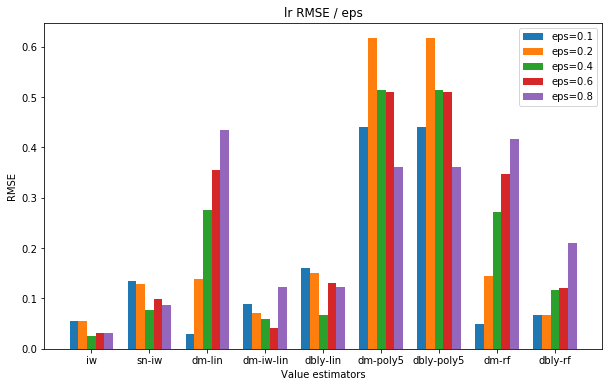

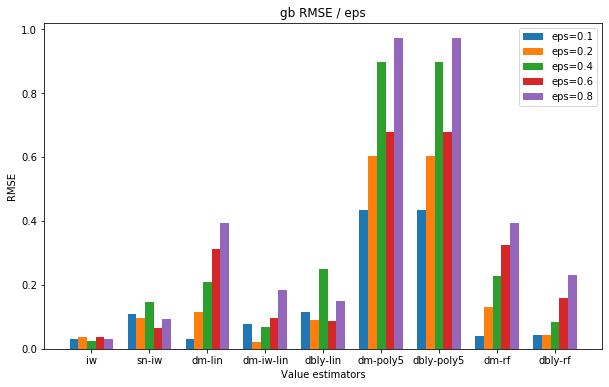

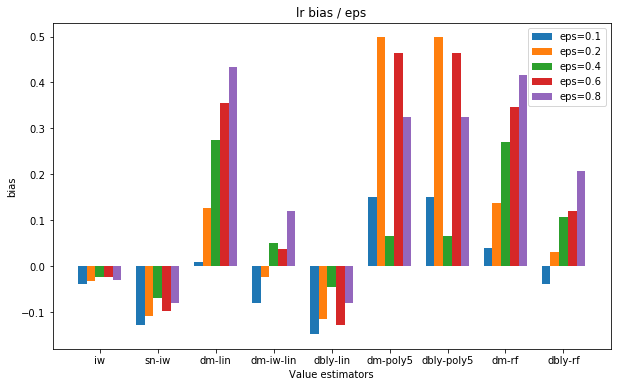

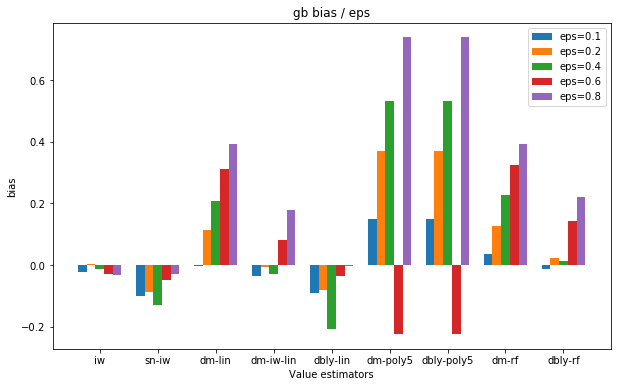

In [25]:
barplot_by_eps(yeast_lr_results, eps_list, 'lr', 'RMSE')
barplot_by_eps(yeast_gb_results, eps_list, 'gb', 'RMSE')

barplot_by_eps(yeast_lr_results, eps_list, 'lr', 'bias')
barplot_by_eps(yeast_gb_results, eps_list, 'gb', 'bias')

### Bean data results

- \# of classes = 7
- Sample size = 13,611

In [27]:
bean_lr_results, bean_gb_results = run_experiments(bean_data, BanditLoggingPolicy, eps_list)

LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.218467
Target policy true value: 0.599069


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.639408,0.014738,0.006591,0.040339,0.042947,0.1
1,sn-iw,0.544877,0.010862,0.004858,-0.054192,0.055270,0.1
2,dm-lin,0.537090,0.010986,0.004913,-0.061979,0.062945,0.1
3,dm-iw-lin,0.590106,0.003035,0.001357,-0.008963,0.009463,0.1
4,dbly-lin,0.585268,0.003862,0.001727,-0.013802,0.014332,0.1
5,dm-poly5,0.629720,0.252149,0.112764,0.030651,0.254005,0.1
6,dbly-poly5,0.600706,0.257962,0.115364,0.001637,0.257967,0.1
7,dm-rf,0.614643,0.003441,0.001539,0.015573,0.015949,0.1
8,dbly-rf,0.599841,0.003226,0.001443,0.000771,0.003317,0.1


GradientBoostingClassifier()
Logging policy value est: 0.222875
Target policy true value: 0.891501


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.946970,0.032972,0.014745,0.055468,0.064528,0.1
1,sn-iw,0.869671,0.011667,0.005218,-0.021830,0.024752,0.1
2,dm-lin,0.735341,0.009781,0.004374,-0.156160,0.156466,0.1
3,dm-iw-lin,0.881221,0.008500,0.003801,-0.010280,0.013339,0.1
4,dbly-lin,0.892550,0.006530,0.002920,0.001049,0.006614,0.1
5,dm-poly5,1.142869,0.560604,0.250710,0.251367,0.614380,0.1
6,dbly-poly5,1.155188,0.566073,0.253155,0.263686,0.624475,0.1
7,dm-rf,0.879678,0.008742,0.003909,-0.011824,0.014704,0.1
8,dbly-rf,0.878884,0.009508,0.004252,-0.012618,0.015799,0.1


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.315209
Target policy true value: 0.599069


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.619792,0.010719,0.004794,0.020723,0.023331,0.2
1,sn-iw,0.535482,0.022552,0.010086,-0.063587,0.067468,0.2
2,dm-lin,0.585082,0.015824,0.007077,-0.013987,0.021119,0.2
3,dm-iw-lin,0.582705,0.003306,0.001478,-0.016364,0.016695,0.2
4,dbly-lin,0.572080,0.003603,0.001611,-0.026990,0.027229,0.2
5,dm-poly5,0.650257,0.115135,0.051490,0.051187,0.126001,0.2
6,dbly-poly5,0.594957,0.118275,0.052894,-0.004112,0.118347,0.2
7,dm-rf,0.640211,0.003147,0.001407,0.041142,0.041262,0.2
8,dbly-rf,0.611781,0.004002,0.001790,0.012712,0.013327,0.2


GradientBoostingClassifier()
Logging policy value est: 0.304433
Target policy true value: 0.891501


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.929162,0.009386,0.004197,0.037661,0.038813,0.2
1,sn-iw,0.864236,0.009911,0.004432,-0.027266,0.029011,0.2
2,dm-lin,0.800168,0.016579,0.007414,-0.091334,0.092826,0.2
3,dm-iw-lin,0.880533,0.008357,0.003738,-0.010969,0.013790,0.2
4,dbly-lin,0.877615,0.005855,0.002618,-0.013886,0.015070,0.2
5,dm-poly5,-1.783327,5.158407,2.306910,-2.674828,5.810669,0.2
6,dbly-poly5,-1.802970,5.159218,2.307273,-2.694471,5.820456,0.2
7,dm-rf,0.905560,0.003909,0.001748,0.014059,0.014592,0.2
8,dbly-rf,0.888407,0.008801,0.003936,-0.003094,0.009329,0.2


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.487387
Target policy true value: 0.599069


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.603617,0.010693,0.004782,0.004548,0.011620,0.4
1,sn-iw,0.524191,0.016811,0.007518,-0.074878,0.076742,0.4
2,dm-lin,0.659471,0.011500,0.005143,0.060402,0.061487,0.4
3,dm-iw-lin,0.585868,0.009662,0.004321,-0.013201,0.016360,0.4
4,dbly-lin,0.560156,0.011775,0.005266,-0.038914,0.040656,0.4
5,dm-poly5,0.744865,0.104021,0.046519,0.145796,0.179100,0.4
6,dbly-poly5,0.658182,0.109576,0.049004,0.059112,0.124504,0.4
7,dm-rf,0.676948,0.005807,0.002597,0.077879,0.078095,0.4
8,dbly-rf,0.615208,0.012463,0.005574,0.016139,0.020391,0.4


GradientBoostingClassifier()
Logging policy value est: 0.488121
Target policy true value: 0.891501


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.909124,0.007725,0.003455,0.017623,0.019241,0.4
1,sn-iw,0.858994,0.020008,0.008948,-0.032508,0.038172,0.4
2,dm-lin,0.874616,0.016884,0.007551,-0.016885,0.023878,0.4
3,dm-iw-lin,0.878847,0.011204,0.005011,-0.012654,0.016902,0.4
4,dbly-lin,0.867531,0.015223,0.006808,-0.023970,0.028396,0.4
5,dm-poly5,0.842612,0.063598,0.028442,-0.048889,0.080218,0.4
6,dbly-poly5,0.781521,0.066388,0.029690,-0.109980,0.128464,0.4
7,dm-rf,0.938930,0.004237,0.001895,0.047429,0.047618,0.4
8,dbly-rf,0.890145,0.012363,0.005529,-0.001356,0.012438,0.4


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.664952
Target policy true value: 0.599069


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.601451,0.007092,0.003171,0.002382,0.007481,0.6
1,sn-iw,0.523887,0.016644,0.007444,-0.075182,0.077002,0.6
2,dm-lin,0.696510,0.014806,0.006622,0.097441,0.098559,0.6
3,dm-iw-lin,0.589033,0.012312,0.005506,-0.010036,0.015884,0.6
4,dbly-lin,0.549243,0.023640,0.010572,-0.049827,0.055150,0.6
5,dm-poly5,0.722310,0.033707,0.015074,0.123241,0.127768,0.6
6,dbly-poly5,0.610540,0.046941,0.020993,0.011471,0.048322,0.6
7,dm-rf,0.705520,0.005942,0.002657,0.106450,0.106616,0.6
8,dbly-rf,0.628912,0.019194,0.008584,0.029843,0.035482,0.6


GradientBoostingClassifier()
Logging policy value est: 0.647563
Target policy true value: 0.891501


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.897852,0.009773,0.004370,0.006351,0.011655,0.6
1,sn-iw,0.868491,0.015234,0.006813,-0.023011,0.027597,0.6
2,dm-lin,0.906037,0.008328,0.003724,0.014536,0.016752,0.6
3,dm-iw-lin,0.890905,0.009356,0.004184,-0.000596,0.009375,0.6
4,dbly-lin,0.874406,0.013385,0.005986,-0.017095,0.021712,0.6
5,dm-poly5,0.964205,0.021687,0.009699,0.072704,0.075870,0.6
6,dbly-poly5,0.892941,0.028114,0.012573,0.001439,0.028151,0.6
7,dm-rf,0.960238,0.000704,0.000315,0.068737,0.068741,0.6
8,dbly-rf,0.905743,0.011291,0.005050,0.014242,0.018175,0.6


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.832721
Target policy true value: 0.599069


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.599181,0.002622,0.001172,0.000111,0.002624,0.8
1,sn-iw,0.519756,0.034708,0.015522,-0.079313,0.086575,0.8
2,dm-lin,0.769859,0.005972,0.002671,0.170789,0.170894,0.8
3,dm-iw-lin,0.586801,0.006887,0.003080,-0.012268,0.014069,0.8
4,dbly-lin,0.512909,0.028143,0.012586,-0.086160,0.090640,0.8
5,dm-poly5,0.690131,0.059614,0.026660,0.091062,0.108840,0.8
6,dbly-poly5,0.558171,0.044282,0.019804,-0.040899,0.060279,0.8
7,dm-rf,0.754487,0.007962,0.003561,0.155418,0.155621,0.8
8,dbly-rf,0.632922,0.019316,0.008638,0.033853,0.038976,0.8


GradientBoostingClassifier()
Logging policy value est: 0.821700
Target policy true value: 0.891501


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.889981,0.007677,0.003433,-0.001521,0.007826,0.8
1,sn-iw,0.846076,0.006432,0.002876,-0.045425,0.045878,0.8
2,dm-lin,0.952672,0.007338,0.003282,0.061170,0.061609,0.8
3,dm-iw-lin,0.888959,0.009754,0.004362,-0.002542,0.010080,0.8
4,dbly-lin,0.851901,0.010654,0.004765,-0.039600,0.041008,0.8
5,dm-poly5,1.002316,0.062906,0.028133,0.110814,0.127425,0.8
6,dbly-poly5,0.900449,0.058196,0.026026,0.008948,0.058880,0.8
7,dm-rf,0.973203,0.000675,0.000302,0.081702,0.081704,0.8
8,dbly-rf,0.897816,0.012506,0.005593,0.006315,0.014010,0.8


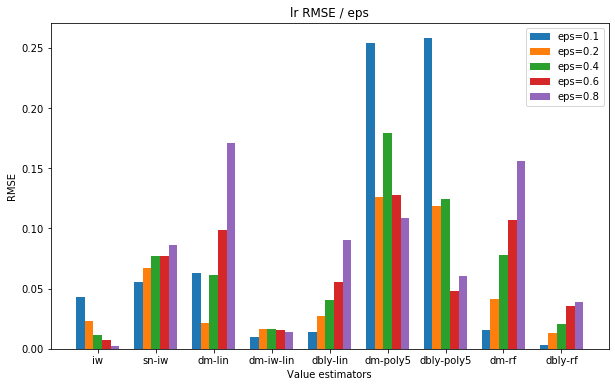

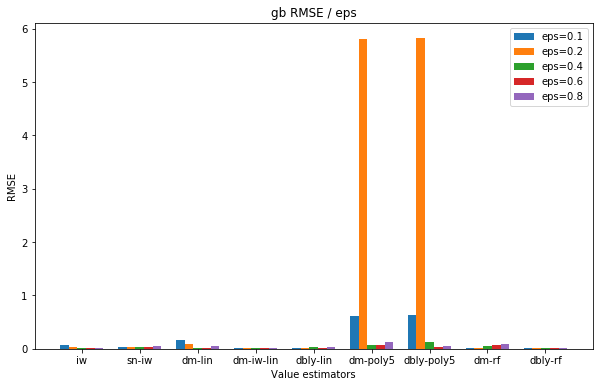

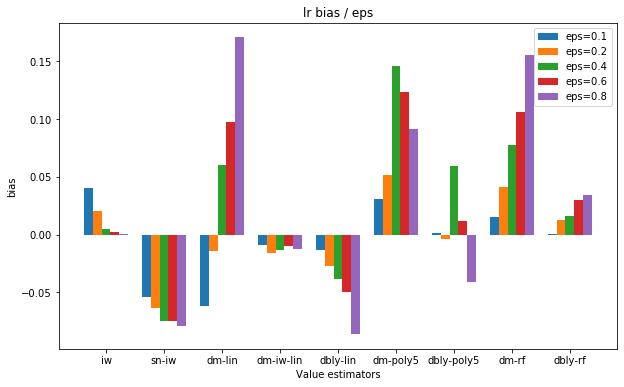

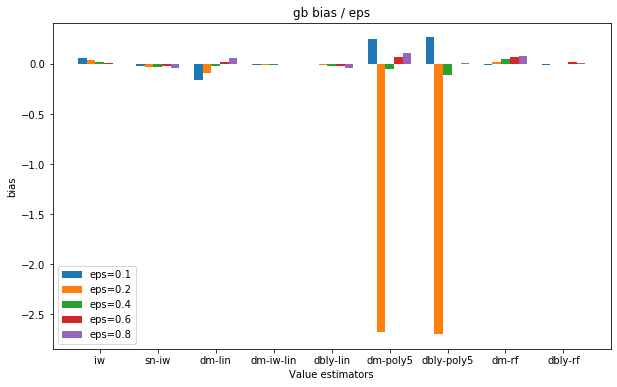

In [28]:
barplot_by_eps(bean_lr_results, eps_list, 'lr', 'RMSE')
barplot_by_eps(bean_gb_results, eps_list, 'gb', 'RMSE')

barplot_by_eps(bean_lr_results, eps_list, 'lr', 'bias')
barplot_by_eps(bean_gb_results, eps_list, 'gb', 'bias')

Direct methods performs well under more random logging policy (small epsilon; less bias towards true label) 

### Letter data results

- \# of classes = 26
- Sample size = 20,000

In [ ]:
letter_lr_results, letter_gb_results = run_experiments(letter_data, BanditLoggingPolicy, eps_list)

LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.136500
Target policy true value: 0.628500


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.638182,0.011867,0.005307,0.009682,0.015316,0.1
1,sn-iw,0.553448,0.015393,0.006884,-0.075052,0.076614,0.1
2,dm-lin,0.481029,0.001185,0.000530,-0.147471,0.147475,0.1
3,dm-iw-lin,0.679161,0.018261,0.008167,0.050661,0.053852,0.1
4,dbly-lin,0.584518,0.012507,0.005593,-0.043982,0.045726,0.1
5,dm-poly5,0.713405,0.009816,0.004390,0.084905,0.085471,0.1
6,dbly-poly5,0.713405,0.009816,0.004390,0.084905,0.085471,0.1
7,dm-rf,0.596713,0.005530,0.002473,-0.031787,0.032264,0.1
8,dbly-rf,0.600148,0.008820,0.003945,-0.028352,0.029692,0.1


GradientBoostingClassifier()
Logging policy value est: 0.133333
Target policy true value: 0.835667


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.848326,0.021943,0.009813,0.012659,0.025333,0.1
1,sn-iw,0.781676,0.009497,0.004247,-0.053991,0.054820,0.1
2,dm-lin,0.479599,0.005471,0.002447,-0.356068,0.356110,0.1
3,dm-iw-lin,0.835826,0.005515,0.002466,0.000159,0.005517,0.1
4,dbly-lin,0.808160,0.008684,0.003884,-0.027506,0.028845,0.1
5,dm-poly5,0.812354,0.015235,0.006813,-0.023312,0.027849,0.1
6,dbly-poly5,0.812354,0.015235,0.006813,-0.023312,0.027849,0.1
7,dm-rf,0.683004,0.006754,0.003021,-0.152662,0.152812,0.1
8,dbly-rf,0.745882,0.007774,0.003477,-0.089784,0.090120,0.1


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.232000
Target policy true value: 0.628500


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.643879,0.022005,0.009841,0.015379,0.026847,0.2
1,sn-iw,0.565758,0.029221,0.013068,-0.062742,0.069213,0.2
2,dm-lin,0.611696,0.011093,0.004961,-0.016804,0.020135,0.2
3,dm-iw-lin,0.693414,0.012075,0.005400,0.064914,0.066027,0.2
4,dbly-lin,0.585192,0.028397,0.012699,-0.043308,0.051788,0.2
5,dm-poly5,0.743646,0.011192,0.005005,0.115146,0.115689,0.2
6,dbly-poly5,0.743646,0.011192,0.005005,0.115146,0.115689,0.2
7,dm-rf,0.678863,0.008234,0.003683,0.050363,0.051032,0.2
8,dbly-rf,0.650568,0.012872,0.005757,0.022068,0.025548,0.2


GradientBoostingClassifier()
Logging policy value est: 0.236333
Target policy true value: 0.835667


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.826065,0.015583,0.006969,-0.009601,0.018303,0.2
1,sn-iw,0.776806,0.017218,0.007700,-0.058860,0.061327,0.2
2,dm-lin,0.606766,0.008117,0.003630,-0.228901,0.229045,0.2
3,dm-iw-lin,0.845189,0.009799,0.004382,0.009523,0.013664,0.2
4,dbly-lin,0.797450,0.016736,0.007485,-0.038217,0.041721,0.2
5,dm-poly5,0.859765,0.013314,0.005954,0.024099,0.027532,0.2
6,dbly-poly5,0.859765,0.013314,0.005954,0.024099,0.027532,0.2
7,dm-rf,0.778016,0.003966,0.001774,-0.057651,0.057787,0.2
8,dbly-rf,0.794773,0.011235,0.005025,-0.040894,0.042409,0.2


LogisticRegression(multi_class='multinomial')
Logging policy value est: 0.421667
Target policy true value: 0.628500


,stat,mean,SD,SE,bias,RMSE,eps
0,iw,0.642445,0.010333,0.004621,0.013945,0.017357,0.4
1,sn-iw,0.569915,0.026406,0.011809,-0.058585,0.064261,0.4
2,dm-lin,0.762252,0.006095,0.002726,0.133752,0.133890,0.4
3,dm-iw-lin,0.722542,0.010189,0.004557,0.094042,0.094593,0.4
4,dbly-lin,0.581236,0.032080,0.014347,-0.047264,0.057123,0.4
5,dm-poly5,0.785347,0.013616,0.006089,0.156847,0.157437,0.4
6,dbly-poly5,0.785347,0.013616,0.006089,0.156847,0.157437,0.4
7,dm-rf,0.763620,0.002335,0.001044,0.135120,0.135140,0.4
8,dbly-rf,0.697954,0.011170,0.004996,0.069454,0.070346,0.4


GradientBoostingClassifier()
Logging policy value est: 0.421333
Target policy true value: 0.835667


In [ ]:
barplot_by_eps(letter_lr_results, eps_list, 'lr', 'RMSE')
barplot_by_eps(letter_gb_results, eps_list, 'gb', 'RMSE')

barplot_by_eps(letter_lr_results, eps_list, 'lr', 'bias')
barplot_by_eps(letter_gb_results, eps_list, 'gb', 'bias')

### Part 2. Run experiments with BanditLoggingPolicyWithFeatureDependency
(Controlling the feature dependency with feature size)

In [ ]:
nfeatures = bean_data.drop(columns='label').columns.size
nfeatures_list = [nfeatures//2, nfeatures//2 +1, nfeatures//2 +2] 
bean_lr_results2, bean_gb_results2 = run_experiments(bean_data, BanditLoggingPolicyWithFeatureDependency, nfeatures_list)